##Self editing memory
Self-editing memory refers to the idea of allowing an LLM to update its own long term memory or persistent memory over time. Its an important aspect of building agents that can learn and improve over time.

###The Agentic Loop

To implement multi-step reasoning with an LLM, there must be a reasoning loop with updates to a state. A single reasoning step corresponding to an LLM is called an agent step. 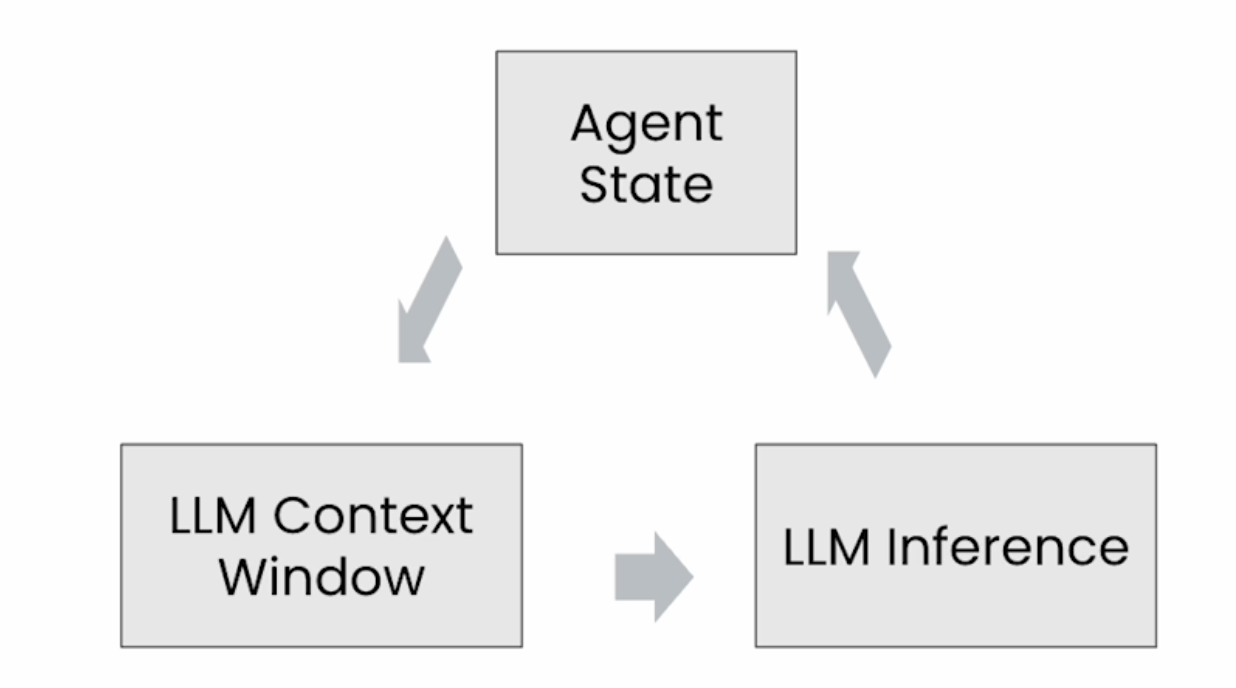

###Adding memory to agents

Long term memory is part of an agent's state which gets compiled into a compiled into a context window, called context compilation. We can make the agent memory self-editing using some special memory tools.

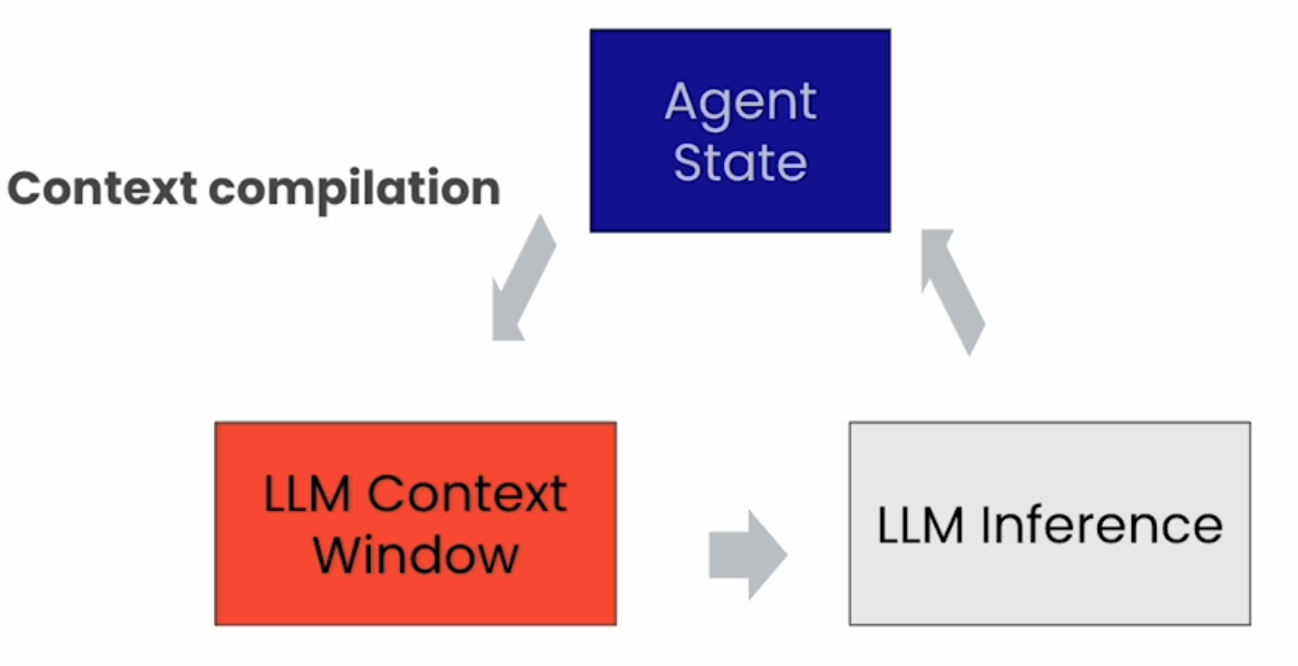

In [ ]:
!pip install openai

In [9]:
import openai
import os
from google.colab import userdata
openai.api_key = userdata.get('OPENAI_API_KEY')

In [10]:
client = openai.OpenAI(api_key = userdata.get('OPENAI_API_KEY'))
model = "gpt-4o-mini"

###Breaking down the LLM context window

LLM's have a context window (the set of tokens that go into the model) that is limited in size. That means we need to be smart about what we place into the context. Usually the context window for an agent is strucuted in a certain way. Depending on the agent framework, the structure will vary, but usually the context window contains:

- A system prompt instructing the agent's behavior
- A conservation history of previous conversations

Because context windows are limited, only some of the conversation history can be included. Some frameworks will also place a recursive summary in the context, or retrieve relevant messages from an external database and also place them into the context. In MemGPT also reserver additional sections of the context for:

- A recursive summary of all previous conversations
- A core memory section that is read-writeable by the agent

###A simple agent's context window

In [11]:
system_prompt = "You are a chatbot."

In [ ]:
# Make the completion request with the tool usage
chat_completion = client.chat.completions.create(
    model=model,
    messages=[
        # system prompt: always included in the context window
        {"role": "system", "content": system_prompt},
        # chat history (evolves over time)
        {"role": "user", "content": "What is my name?"},
    ]
)
chat_completion.choices[0].message.content

###Adding memory to the context

In [13]:
agent_memory = {"human": "Name: Bob"}
system_prompt = "You are a chatbot. " \
+ "You have a section of your context called [MEMORY] " \
+ "that contains information relevant to your conversation"

In [ ]:
import json


chat_completion = client.chat.completions.create(
    model=model,
    messages=[
        # system prompt
        {"role": "system", "content": system_prompt + "[MEMORY]\n" + json.dumps(agent_memory)},
        # chat history
        {"role": "user", "content": "What is my name?"},
    ],
)
chat_completion.choices[0].message.content

###Modifying the memory with tools

We first need to define a memory save tool. In order to allow the agent to save new memory, we implement a simple tool that appends to a section of the memory dictionary which we will pass to the agent.

In [15]:
# defining a memory editing tool

# Instead of directly providing the name in the agent's memory, we'll instead start with a blank memory object and provide a function that can edit the memory object.

agent_memory = {"human": "", "agent": ""}

def core_memory_save(section: str, memory: str):
    agent_memory[section] += '\n'
    agent_memory[section] += memory

In [16]:
agent_memory

{'human': '', 'agent': ''}

In [17]:
core_memory_save("human","The human's name is Charles")

In [18]:
agent_memory

{'human': "\nThe human's name is Charles", 'agent': ''}

To inform our agent of this tool and how to use it, we need to create a tool schema that OpenAI can process. This includes a description of how to use the tool, and the parameters the agent must generate to input into the tool.

In [19]:
# tool description
core_memory_save_description = "Save important information about you," \
+ "the agent or the human you are chatting with."

# arguments into the tool (generated by the LLM)
# defines what the agent must generate to input into the tool
core_memory_save_properties = \
{
    # arg 1: section of memory to edit
    "section": {
        "type": "string",
        "enum": ["human", "agent"],
        "description": "Must be either 'human' " \
        + "(to save information about the human) or 'agent'" \
        + "(to save information about yourself)",
    },
    # arg 2: memory to save
    "memory": {
        "type": "string",
        "description": "Memory to save in the section",
    },
}

# tool schema (passed to OpenAI)
core_memory_save_metadata = \
    {
        "type": "function",
        "function": {
            "name": "core_memory_save",
            "description": core_memory_save_description,
            "parameters": {
                "type": "object",
                "properties": core_memory_save_properties,
                "required": ["section", "memory"],
            },
        }
    }

Now we can pass the tool call into the agent.

In [ ]:
agent_memory = {"human": ""}
system_prompt = "You are a chatbot. " \
+ "You have a section of your context called [MEMORY] " \
+ "that contains information relevant to your conversation"

chat_completion = client.chat.completions.create(
    model=model,
    messages=[
        # system prompt
        {"role": "system", "content": system_prompt},
        # memory
        {"role": "system", "content": "[MEMORY]\n" + json.dumps(agent_memory)},
        # chat history
        {"role": "user", "content": "My name is Bob"},
    ],
    # tool schemas
    tools=[core_memory_save_metadata]
)
response = chat_completion.choices[0]
response

Unfortunately, OpenAI isn't going to actually execute the tool, so we have to do this ourselves. Lets take the arguments specified in the tool call response we just got to run the tool.

In [ ]:
arguments = json.loads(response.message.tool_calls[0].function.arguments)
arguments

In [ ]:
# run the function with the specified arguments
core_memory_save(**arguments)
agent_memory

Now, we can see how the agent responds differently as the memory has been updated.

In [ ]:
chat_completion = client.chat.completions.create(
    model=model,
    messages=[
        # system prompt
        {"role": "system", "content": system_prompt},
        # memory
        {"role": "system", "content": "[MEMORY]\n" + json.dumps(agent_memory)},
        # chat history
        {"role": "user", "content": "what is my name"},
    ],
    tools=[core_memory_save_metadata]
)
response = chat_completion.choices[0]
response.message

###Implementing an agentic loop

We implement a simple step function for the agent. The function responds to the user message but allows the agent to take multiple actions in sequence, and returns to the user when a message (that does not call a tool) is sent.

In [22]:
agent_memory = {"human": ""}

In [23]:
system_prompt_os = system_prompt \
+ "\n. You must either call a tool (core_memory_save) or" \
+ "write a response to the user. " \
+ "Do not take the same actions multiple times!" \
+ "When you learn new information, make sure to always" \
+ "call the core_memory_save tool."

In [ ]:
def agent_step(user_message, chat_history = []):

    # prefix messages with system prompt and memory
    messages = [
        # system prompt
        {"role": "system", "content": system_prompt_os},
        # memory
        {
            "role": "system",
            "content": "[MEMORY]\n" + json.dumps(agent_memory)
        },
    ]

    # append the chat history
    messages += chat_history


    # append the most recent message
    messages.append({"role": "user", "content": user_message})

    # agentic loop
    while True:
        chat_completion = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=[core_memory_save_metadata]
        )
        response = chat_completion.choices[0]

        # update the messages with the agent's response
        messages.append(response.message)

        # if NOT calling a tool (responding to the user), return
        if not response.message.tool_calls:
            messages.append({
                "role": "assistant",
                "content": response.message.content
            })
            return response.message.content

        # if calling a tool, execute the tool
        if response.message.tool_calls:
            print("TOOL CALL:", response.message.tool_calls[0].function)

            # add the tool call response to the message history
            messages.append({"role": "tool", "tool_call_id": response.message.tool_calls[0].id, "name": "core_memory_save", "content": f"Updated memory: {json.dumps(agent_memory)}"})

            # parse the arguments from the LLM function call
            arguments = json.loads(response.message.tool_calls[0].function.arguments)

            # run the function with the specified arguments
            core_memory_save(**arguments)

In [ ]:
agent_step("my name is bob.")